## Sandbox for getting article pair similarity after filtering by named entities 

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
import re
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance 
import seaborn as sns

In [2]:
#get data with content, embeddings, and named entities 
df = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/dataWithEmbeddings.tsv", sep="\t", converters={"embedding":lambda x: np.array(x.strip("[]").split(), dtype=float)})

/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (2,3,7,10,11,12,13,14,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,39,40,41,42) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
print(df.shape)
df["key"] = df["key"].apply(lambda x: x.strip())
print(df.drop_duplicates(subset=["key"]).shape)

(308837, 48)
(308837, 48)


In [4]:
print(max(pd.to_datetime(df["date"])))
print(min(pd.to_datetime(df["date"])))
print(df.shape)

2021-09-01 00:00:00
2021-05-01 00:00:00
(308837, 48)


In [5]:
testDf = df[["key", "topics", "embedding"]]

print("parsing")

def cleanList(inList): 
    return [str(re.sub("[^a-zA-Z0-9 ]", "", item).lower()) for item in inList]

def parseList(inStr): 
    split = inStr.split("\'), (\'")
    return [cleanList(item.split("', '")) for item in split]

#parse topics from string to actual list of tuples 
testDf["topics"] = testDf["topics"].apply(parseList)

print("parsed")

#test out idea for creating reverse mapping 
testDf = testDf.dropna(subset=["topics"])

#bring each tuple into its own row 
testDf = testDf.explode("topics")

#bring each tuple entry into its own column 
#split ent_type, entity pairs to columns 
testDf[["ent_type","entity"]] = pd.DataFrame(testDf["topics"].tolist(), index=testDf.index)

print("formatted") 

#keep only the entity types that may be interesting 
toKeep = ["org","event", "person", "work_of_art", "product"]
testDf = testDf[testDf["ent_type"].isin(toKeep)]

grouped = testDf[["embedding", "ent_type", "entity", "key"]].groupby(by=["ent_type", "entity"]).agg(list)

parsing


<ipython-input-5-80b088d75f01>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDf["topics"] = testDf["topics"].apply(parseList)


parsed
formatted


In [6]:
grouped["articleNum"] = grouped["key"].apply(len)
grouped.head()

embedding  \
ent_type entity                                                                 
event     fields2value1970  [[-0.00773029588, -0.00490123546, 0.0179314595...   
          game 2            [[-0.0185301453, 0.0250518899, 0.0244161058, -...   
          game of thrones   [[-0.0230182633, 0.0624324679, 0.00821057428, ...   
          hall of fame      [[-0.0627424344, 0.0551135093, 0.00766856782, ...   
          mars 2020         [[-0.0456677824, -0.00853861216, 0.0276035238,...   

                                                                          key  \
ent_type entity                                                                 
event     fields2value1970  [hillsborofreepress_Infinity_Fitness_has_offic...   
          game 2            [theseattletimes_76ers’_Rivers_seeks_fill-in_f...   
          game of thrones   [thenewyorktimes_Seth_Meyers_Explains_How_‘For...   
          hall of fame      [dailydemocrat_49ers’_Hall_of_Fame:_John_Taylo...   
          mars 2020                   [cbsnews_How_NASA_flew_a_drone_on_Mars]   

                            articleNum  
ent_type entity                         
event     fields2value1970           6  
          game 2                     1  
          game of thrones            1  
          hall of fame               3  
          mars 2020                  1

In [7]:
grouped.shape

(1011755, 3)

In [8]:
groupedLean = grouped[(grouped["articleNum"] > 5) & (grouped["articleNum"] < 500)]
groupedLean.shape

(112774, 3)

Text(0.5, 0.98, 'Named Entity Cluster Size Distribution')

<Figure size 432x288 with 0 Axes>

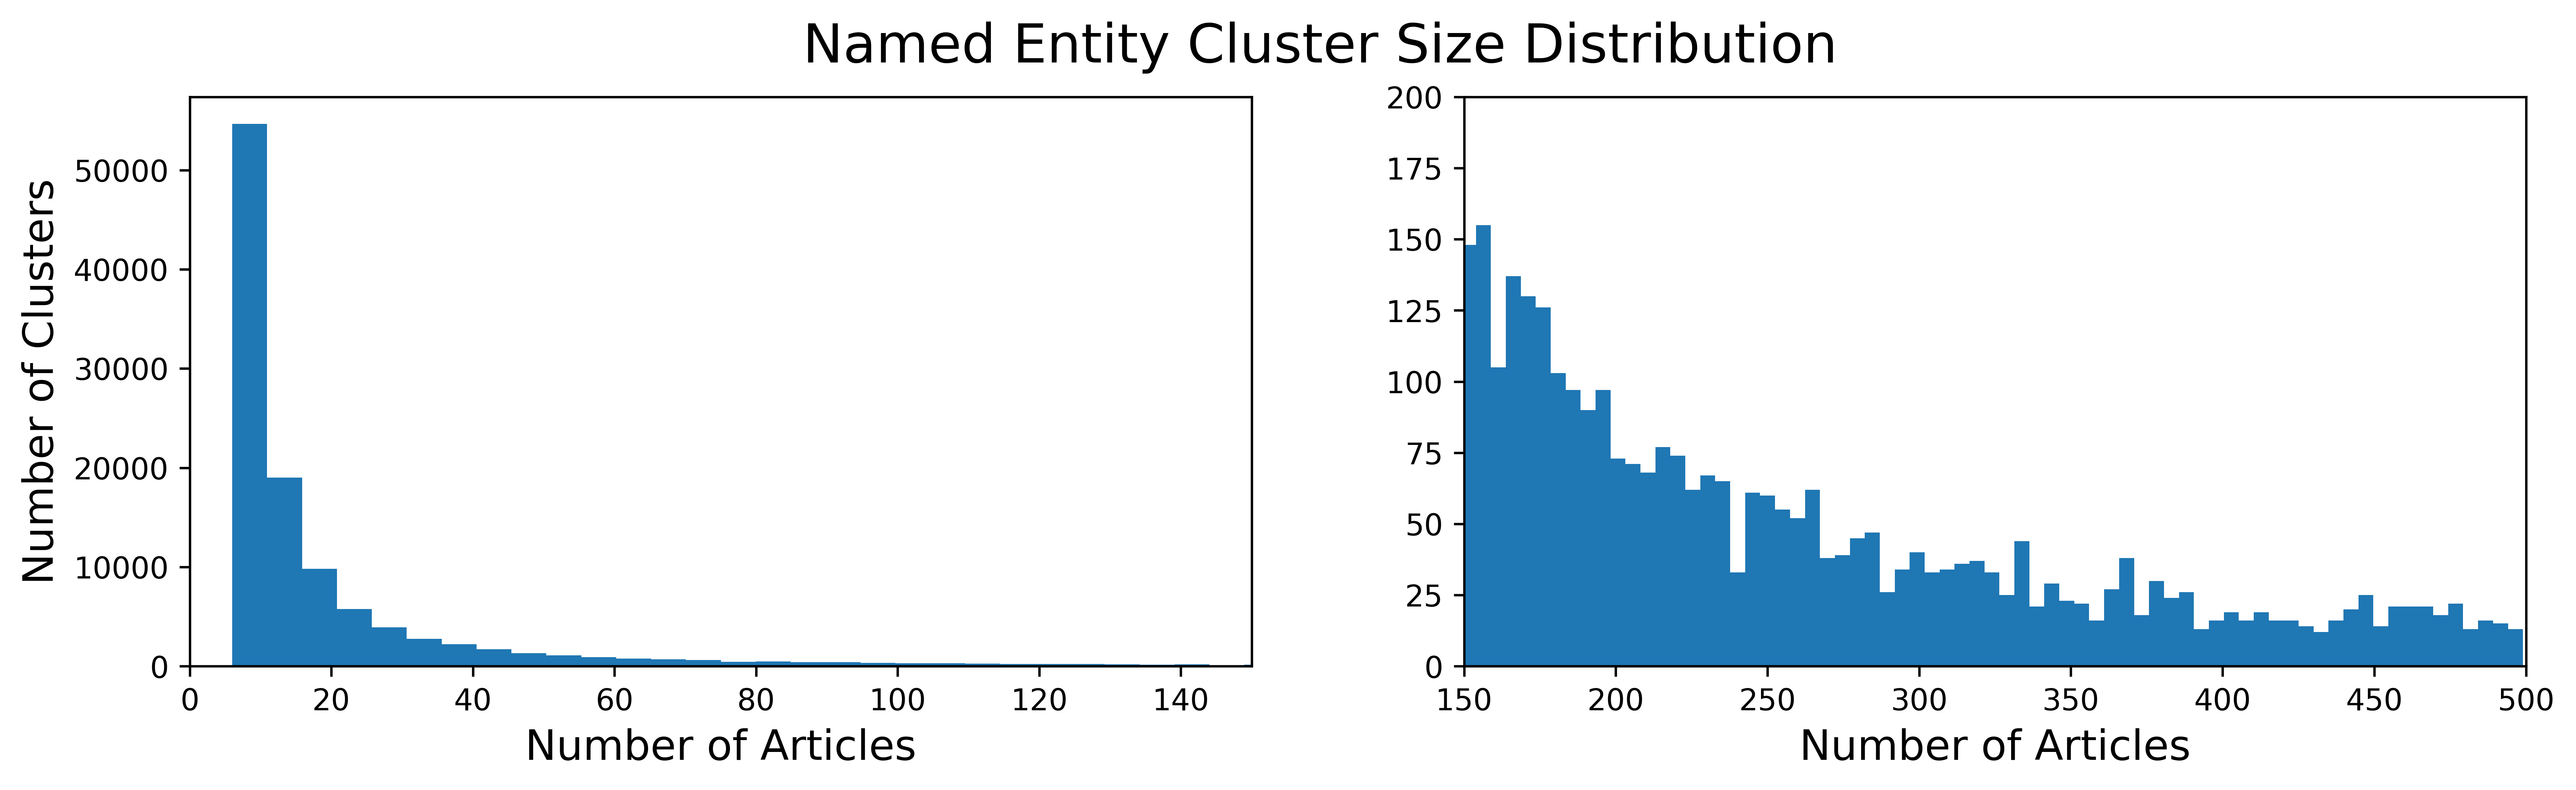

In [9]:
plt.clf()
plt.rcParams['figure.dpi'] = 600
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[14, 3.5])

axs[0].hist(groupedLean["articleNum"], bins=100)
axs[0].set_xlim([0, 150])
axs[0].set_xlabel("Number of Articles", size=14)
axs[0].set_ylabel("Number of Clusters", size=14)

axs[1].hist(groupedLean["articleNum"], bins=100)
axs[1].set_xlim([150, 500])
axs[1].set_ylim([0, 200])
axs[1].set_xlabel("Number of Articles", size=14)
fig.suptitle("Named Entity Cluster Size Distribution", size=18)


## Some entity examples 

In [10]:
print(grouped.loc[("person", "donald trump"), ["articleNum"]])
print(grouped.loc[("org", "republican party"), ["articleNum"]])
print(grouped.loc[("person", "george floyd"), ["articleNum"]])
print(grouped.loc[("person", "covid19"), ["articleNum"]])

articleNum    14070
Name: (person, donald trump), dtype: int64
articleNum    610
Name: (org, republican party), dtype: int64
articleNum    3416
Name: (person, george floyd), dtype: int64
articleNum    11457
Name: (person, covid19), dtype: int64


In [11]:
groupedLean.iloc[3,:]

embedding     [[-0.0297710318, 0.00756559148, 0.00346088805,...
key           [deseretnews_How_pride_in_2002_Winter_Olympics...
articleNum                                                   11
Name: (event, 911), dtype: object

In [88]:
#we want to get the similarity of articles within clusters and see if it is reasonable 
plt.rcParams['figure.dpi'] = 300

def showClustSim(inRow, tokenCutoffs = [1, 9], includeLabs = True): 
    fig, axs = plt.subplots(figsize=[8,4])
    embedding = inRow["embedding"]
    outList = np.empty(shape=(len(embedding), len(embedding)))
    
    for i, outer in enumerate(embedding): 
        innerList = []
        for j, inner in enumerate(embedding): 
            outList[i][j] = 1 - distance.cosine(outer, inner)

    #groupedLean["key"][0]
    labels = [" ".join(lab.split("_")[tokenCutoffs[0]:tokenCutoffs[1]]) for lab in inRow["key"]]
    
    if includeLabs == True: 
        sns.heatmap(outList, cmap="coolwarm", center=0, annot=True, xticklabels="", yticklabels="")
        axs.set_xticklabels(labels, rotation=30, ha="right")
    else: 
        sns.heatmap(outList, cmap="coolwarm", center=0, yticklabels=False, xticklabels=False)
        
    
    plt.title("Entity Cluster: " + inRow.name[1], size=14)
    
#create a heatmap for sanity checking. Maybe need to filter out content using key from dataframe? 

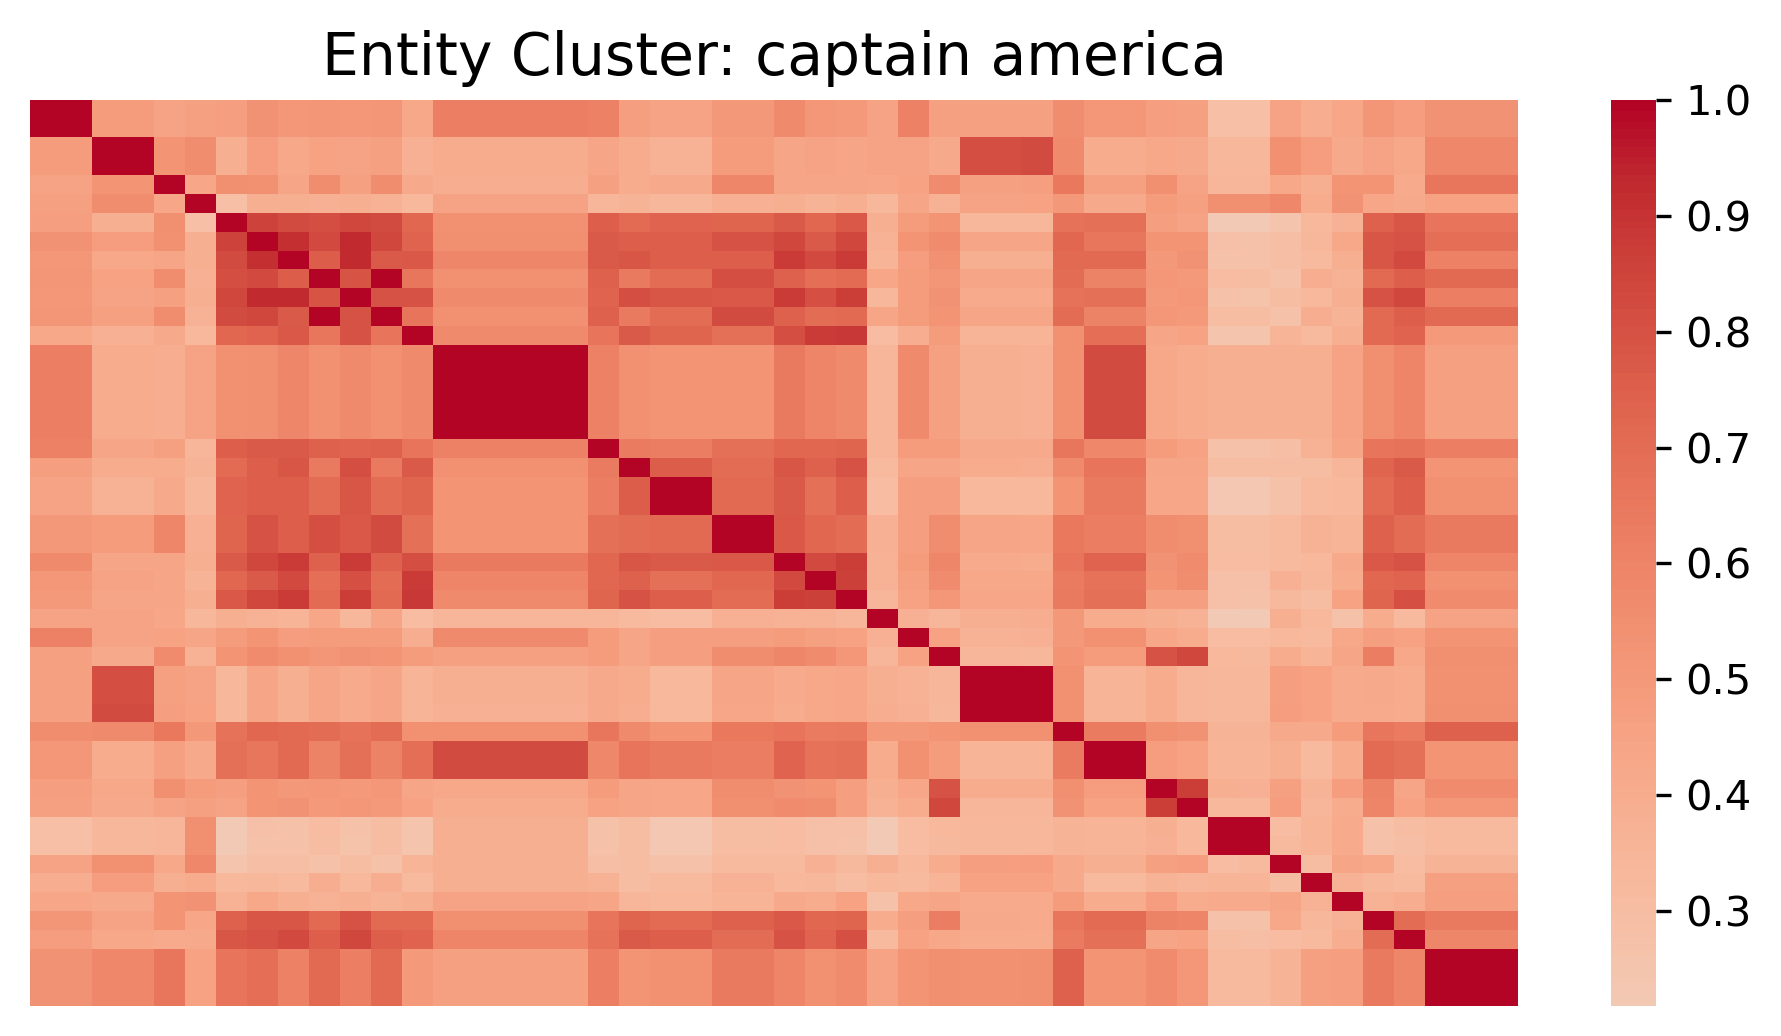

In [96]:
randomSize30 = groupedLean[groupedLean["articleNum"] == 48].iloc[20,:]
showClustSim(randomSize30, includeLabs=False)

## 911 entity. Gives cluster about pulling out of Afghanistan 

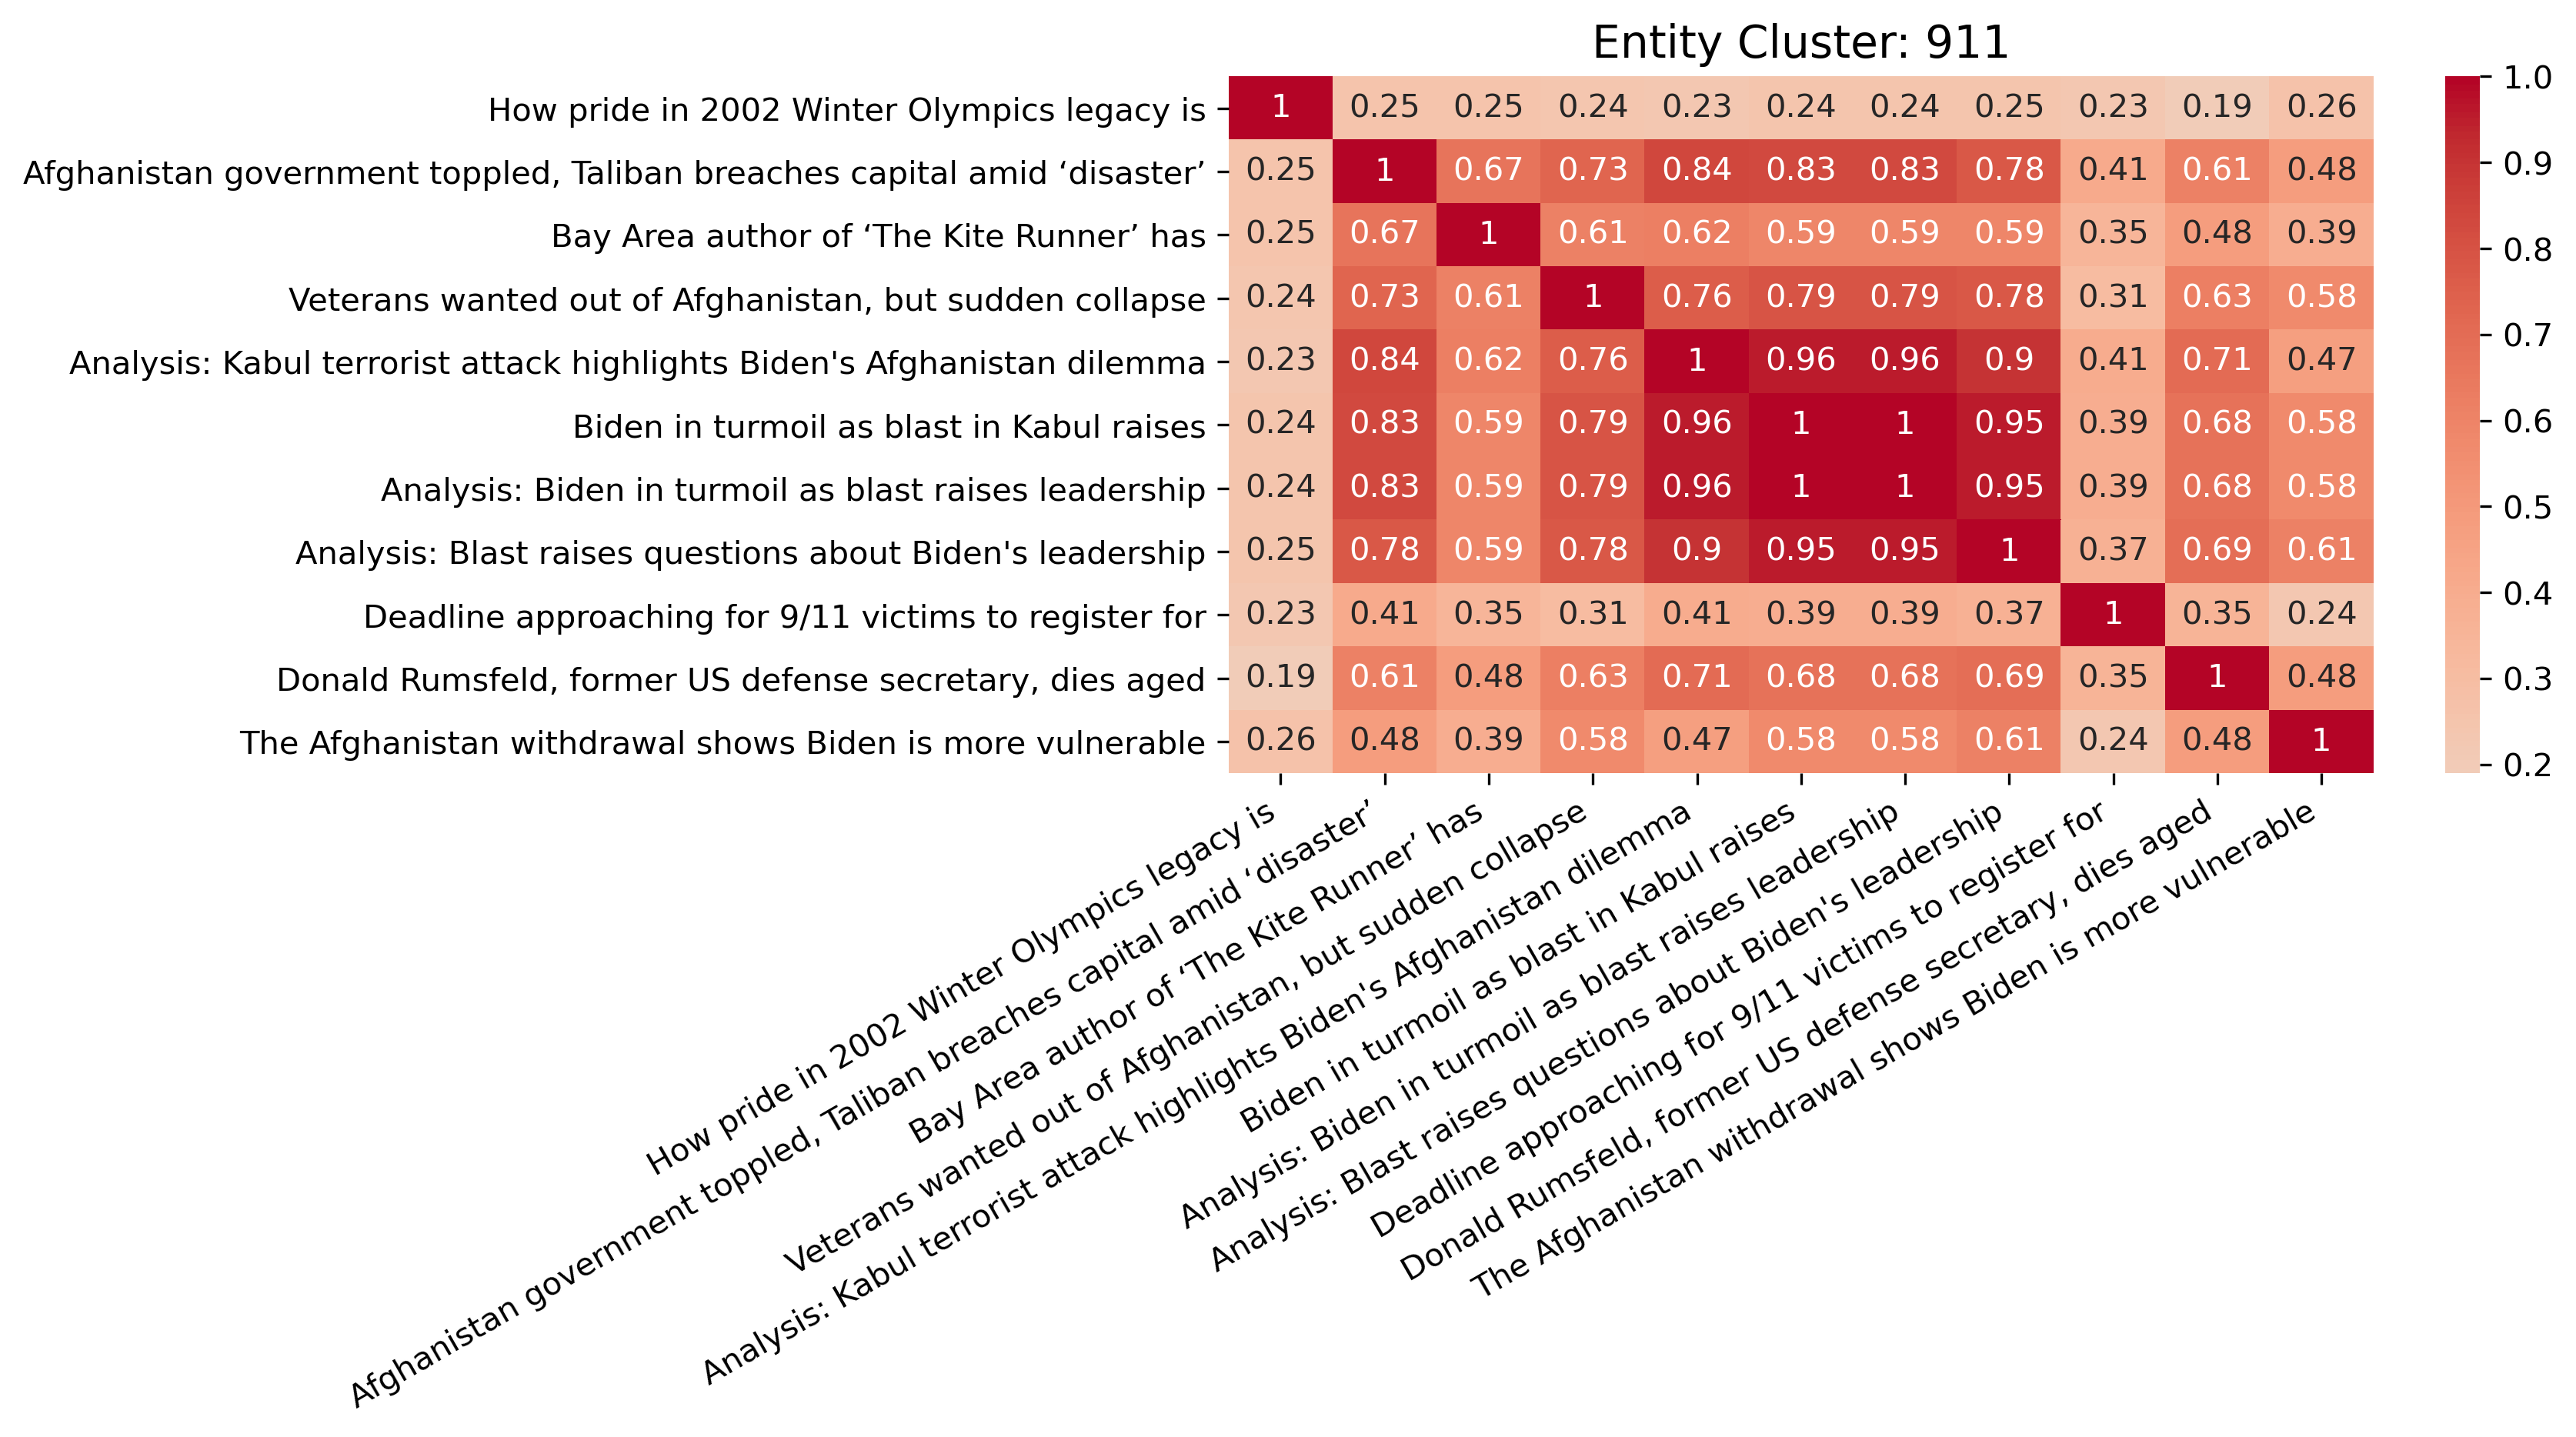

In [13]:
ent911 = groupedLean.iloc[3]  
showClustSim(ent911)

## Interesting example of the same exact story from multiple different sources 

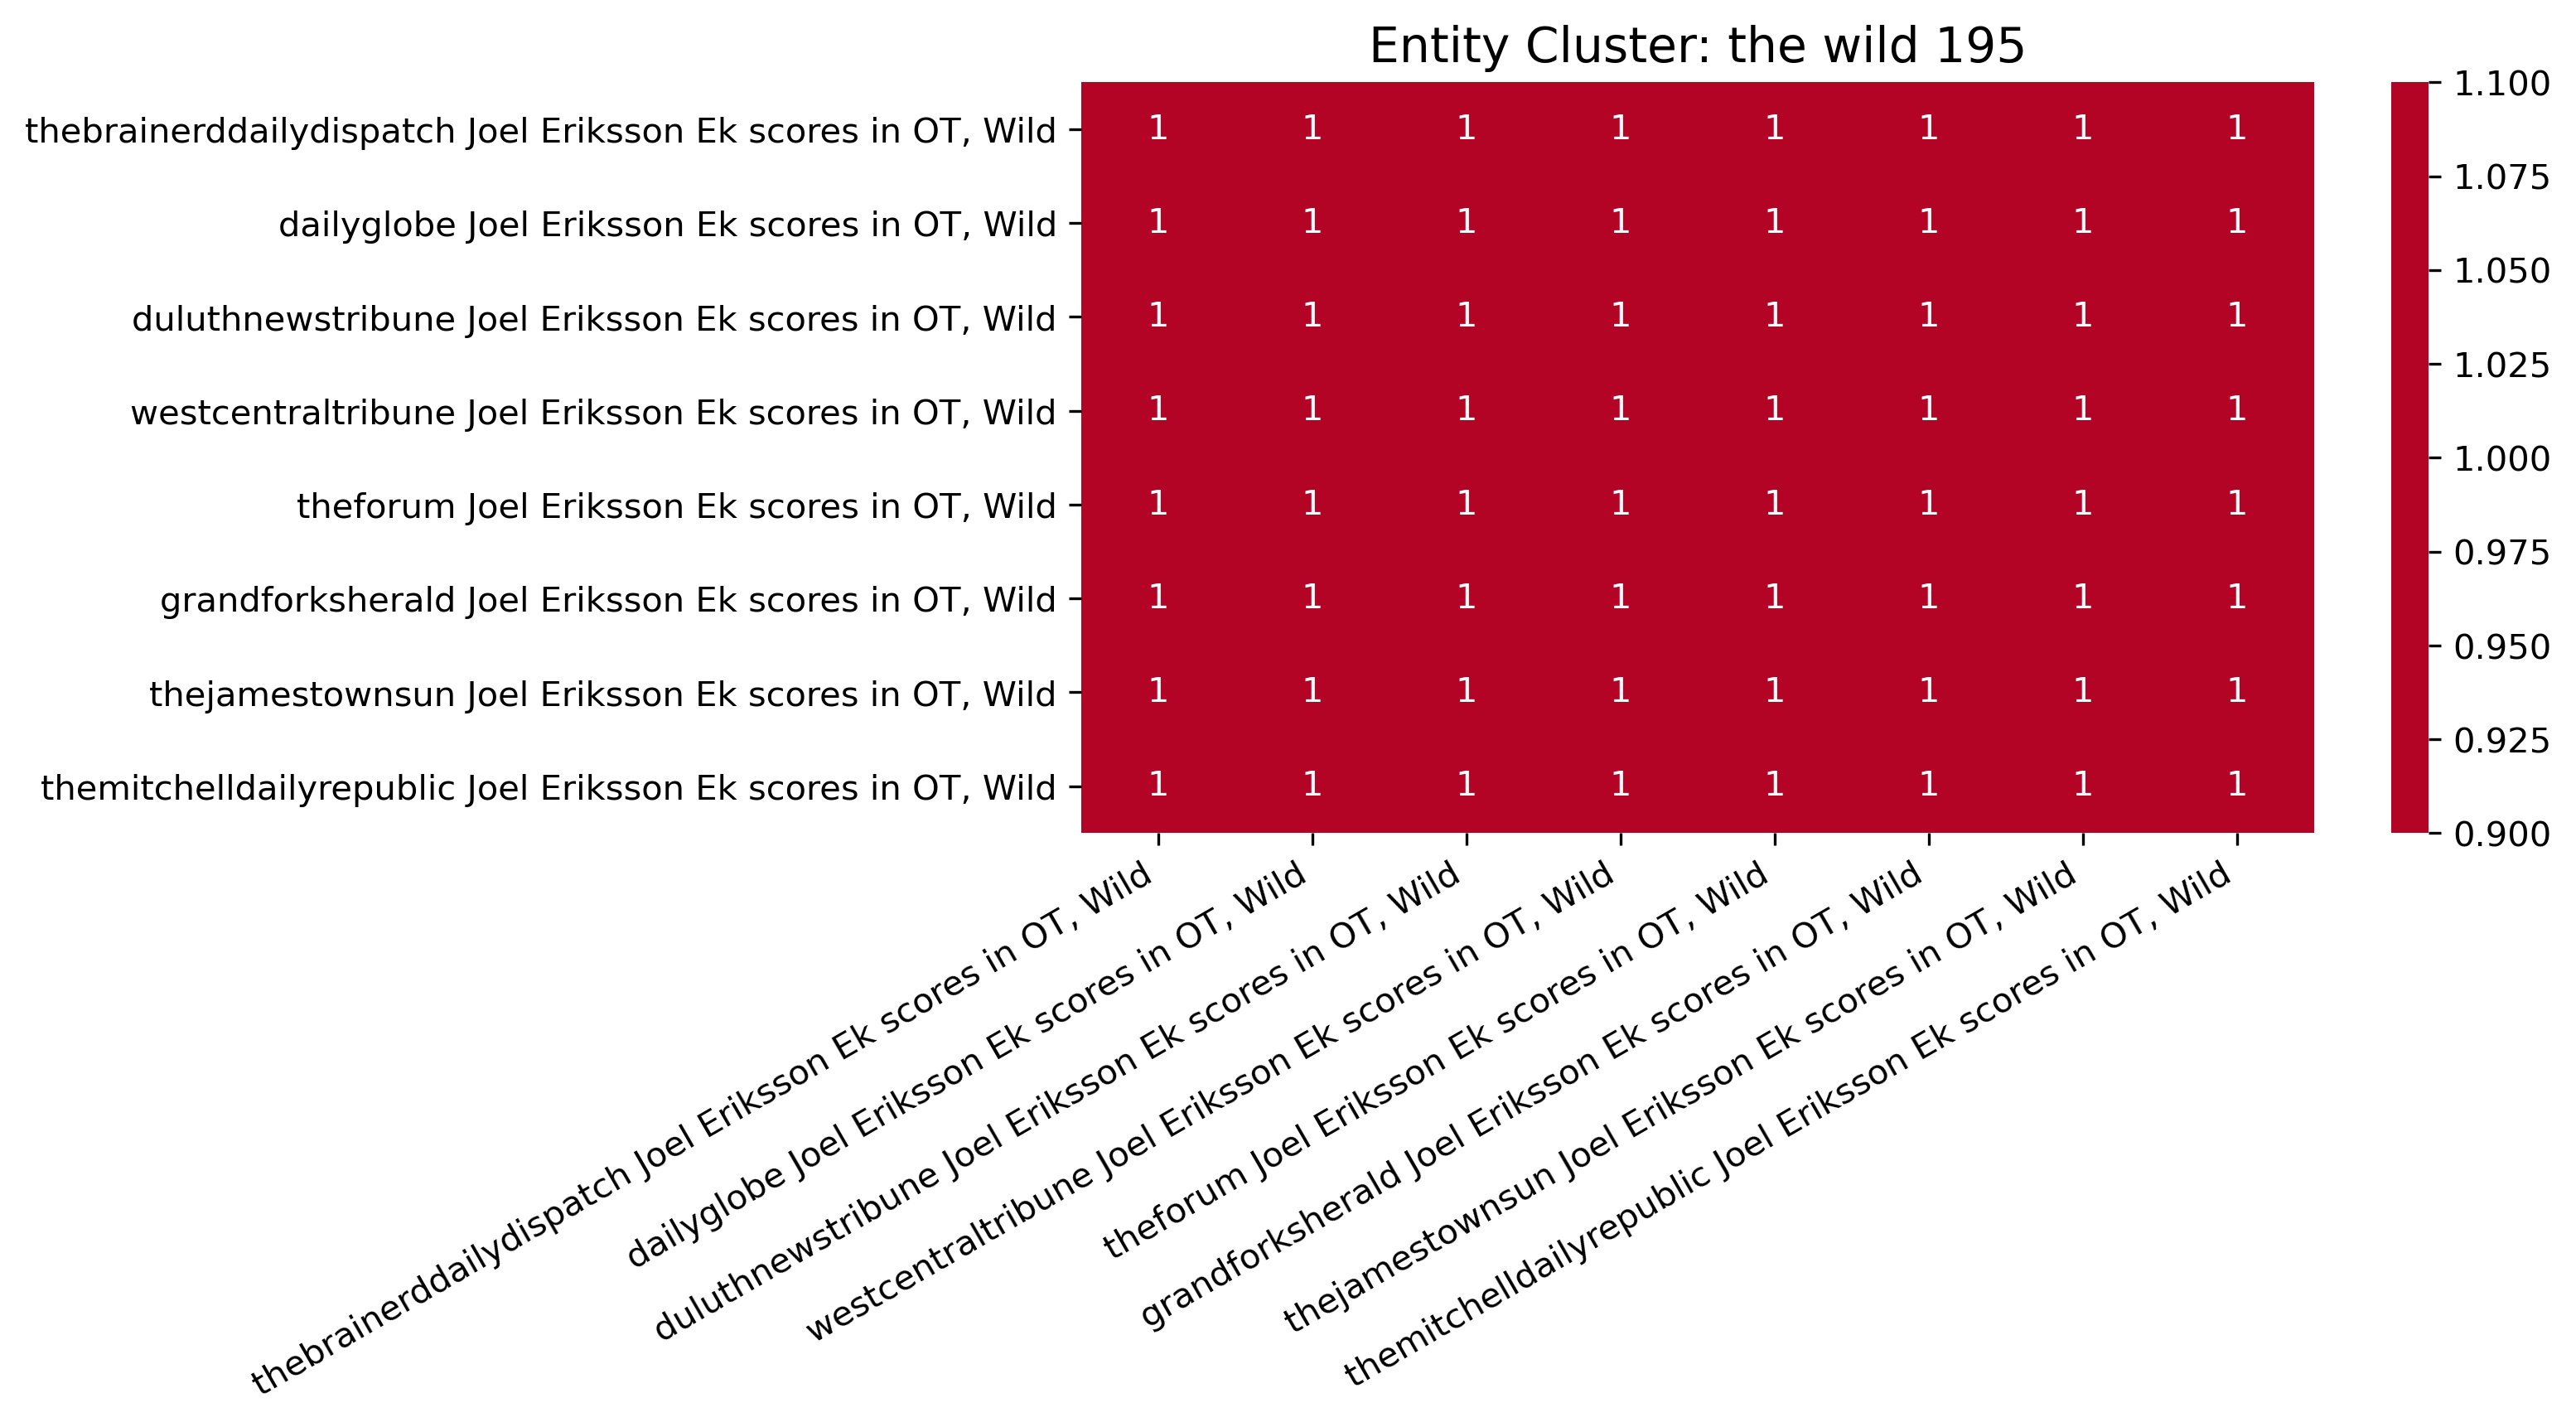

In [14]:
testRow = groupedLean.iloc[1002]
showClustSim(testRow, tokenCutoffs=[0, 8])


In [15]:
#what are the different types of entities we are working with? 
#PRODUCT could be quite interesting.. what are the market effects? 
groupedLean.index.get_level_values(0).unique()

Index(['event', 'org', 'person', 'product'], dtype='object', name='ent_type')

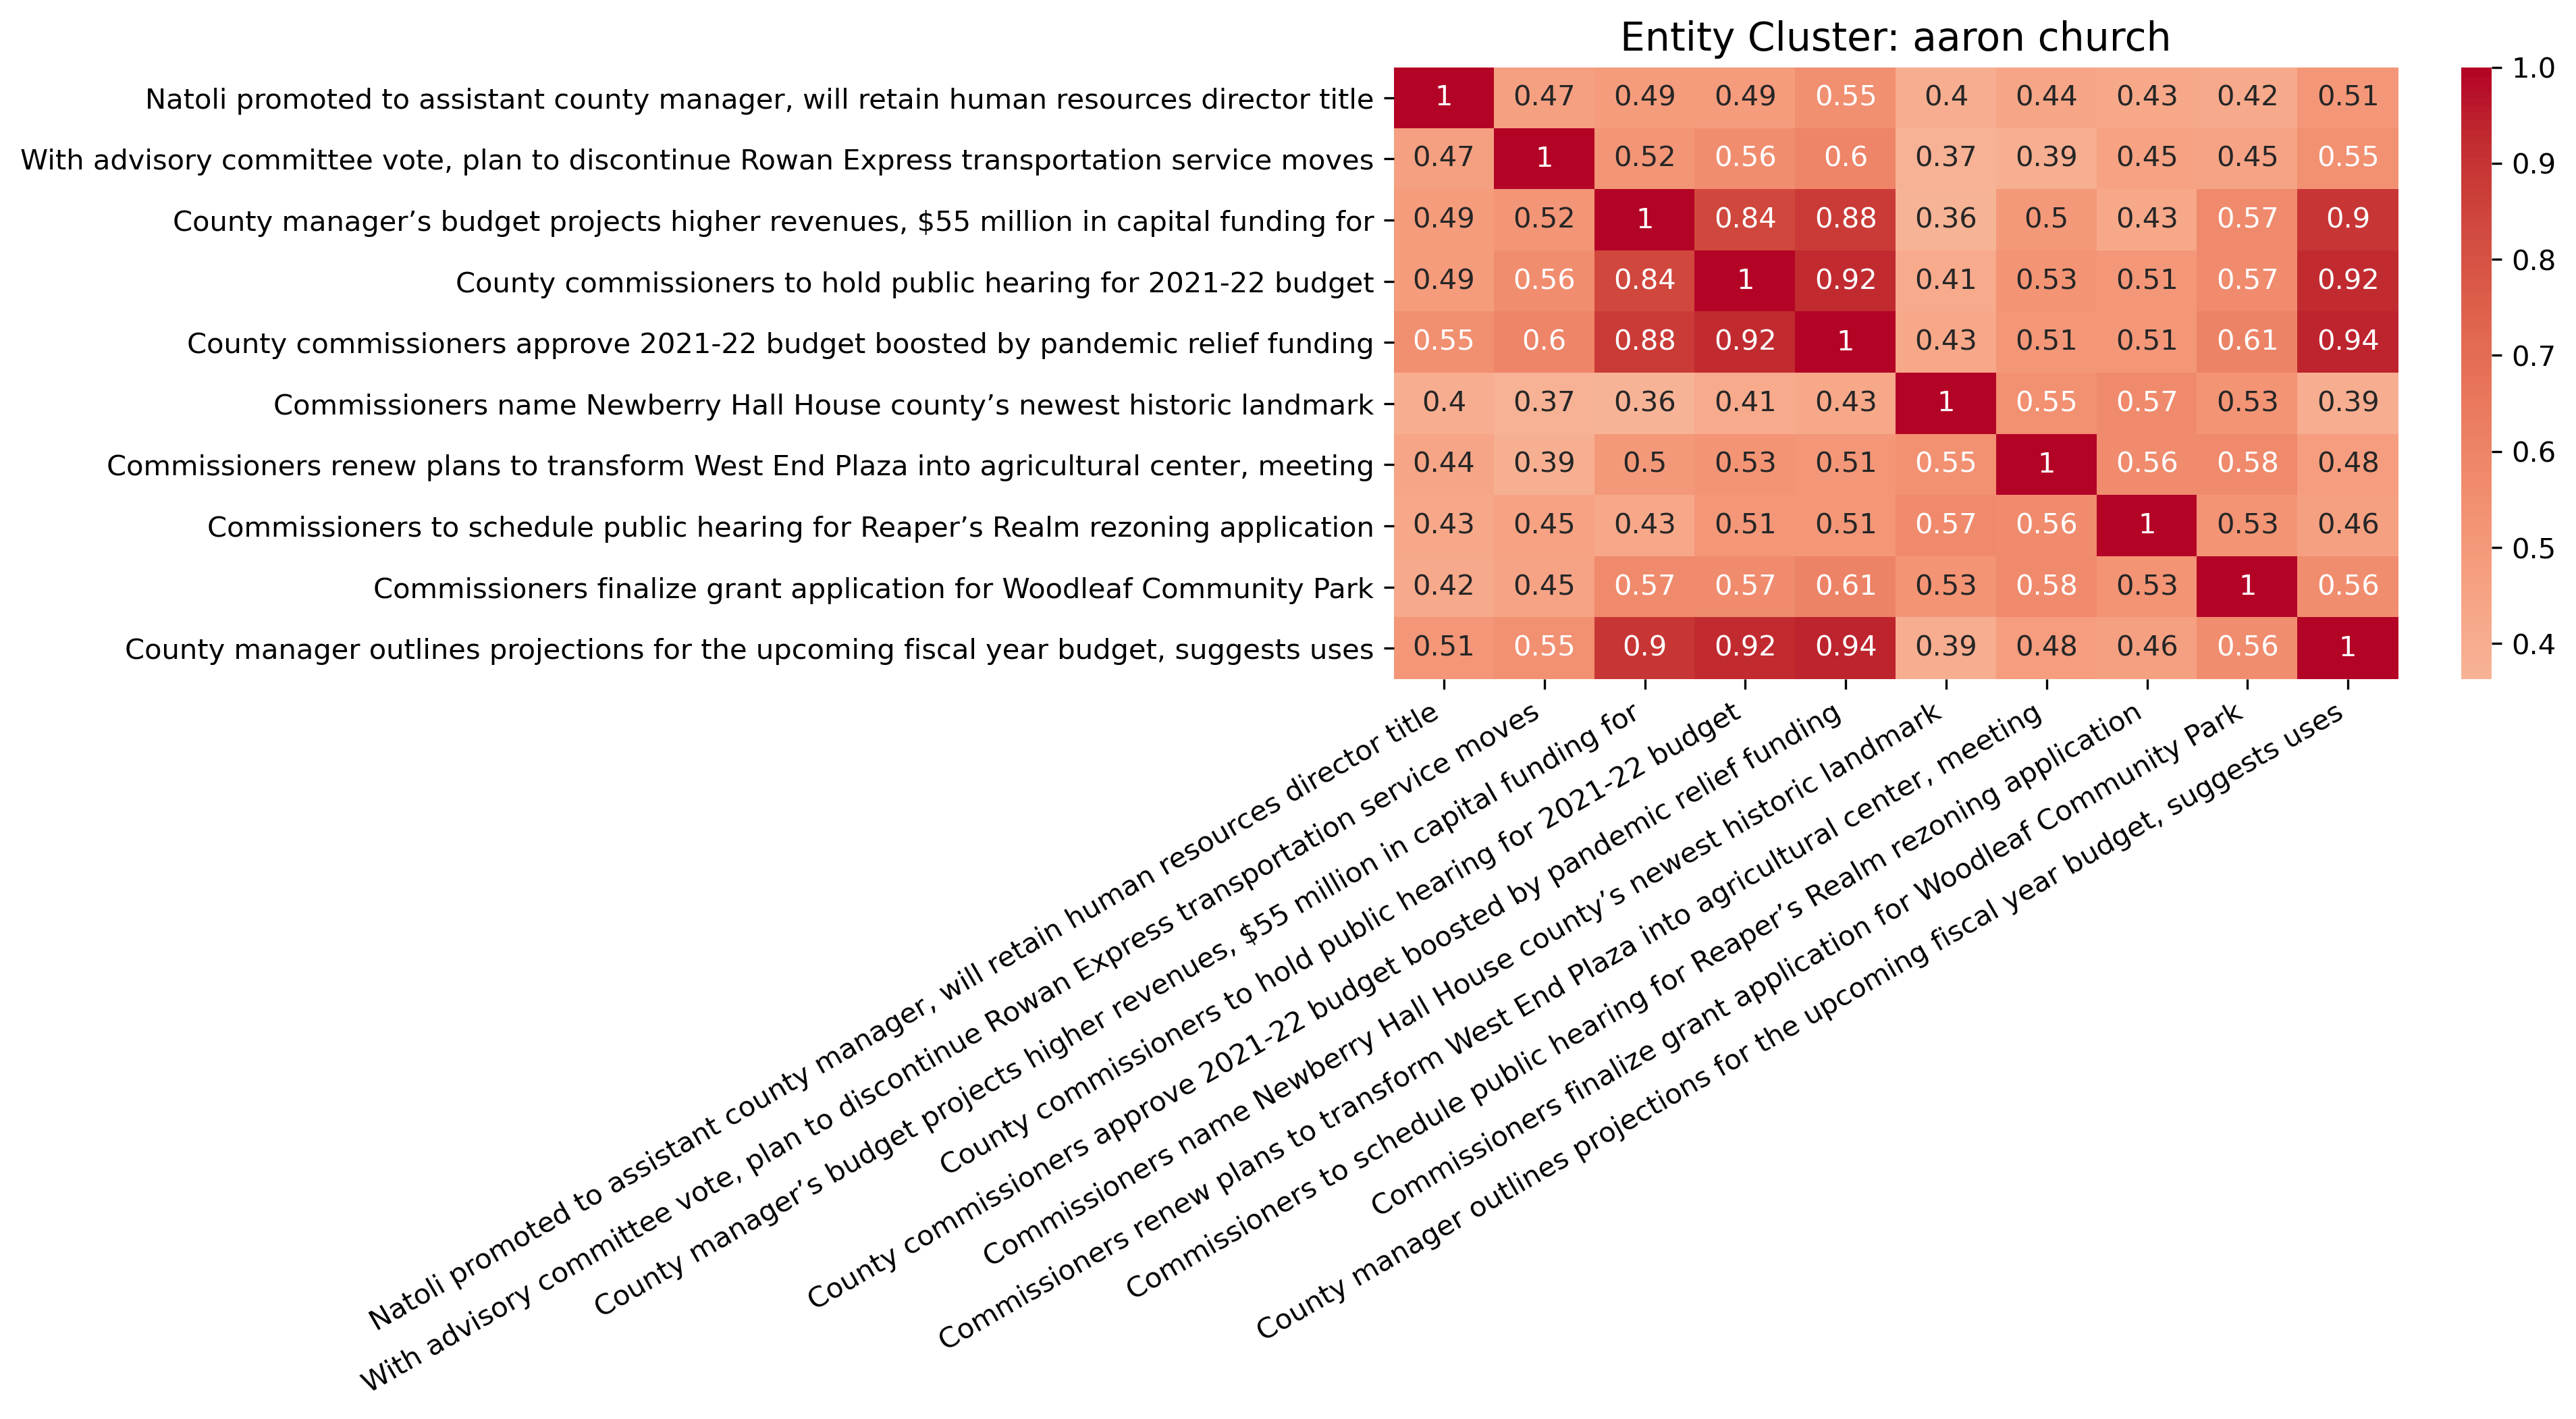

In [16]:
eventDf = groupedLean.loc["person"]
eventDf.iloc[100:110, :]

#let's check out arron church because why not.. 
showClustSim(groupedLean.loc[("person", "aaron church")], tokenCutoffs = [1, 13])

In [20]:
def getDist(embList, cutoff=None): 
    outList = np.empty(shape=(len(embList), len(embList)))
    
    for i, outer in enumerate(embList): 
        innerList = []
        for j, inner in enumerate(embList): 
            dist = distance.cosine(outer, inner)
            sim = 1 - dist
            if cutoff == None: 
                outList[i][j] = dist
            else: 
                outList[i][j] = 1 - int(dist <= cutoff)
                
    return np.array(outList)


In [21]:
row = grouped.loc[("org", "republican party")]

#get distance with a cutoff. We say anything with > distance is not the same news event 
distArr = getDist(row["embedding"], cutoff=.15)
distArr

#linkage shouldn't matter between single and complete, since the distances will all be 1
#so distance threshold of .1 puts only articles that are connected together 
agg = AgglomerativeClustering(linkage="single", compute_distances=True, affinity="precomputed", distance_threshold=.01, n_clusters=None)
clustered = agg.fit_predict(distArr)

clusteredDf = pd.DataFrame({"cluster":clustered, "key": row["key"]})

(array([295.,  12.,   6.,   2.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 1.  ,  3.35,  5.7 ,  8.05, 10.4 , 12.75, 15.1 , 17.45, 19.8 ,
        22.15, 24.5 , 26.85, 29.2 , 31.55, 33.9 , 36.25, 38.6 , 40.95,
        43.3 , 45.65, 48.  ]),
 <BarContainer object of 20 artists>)

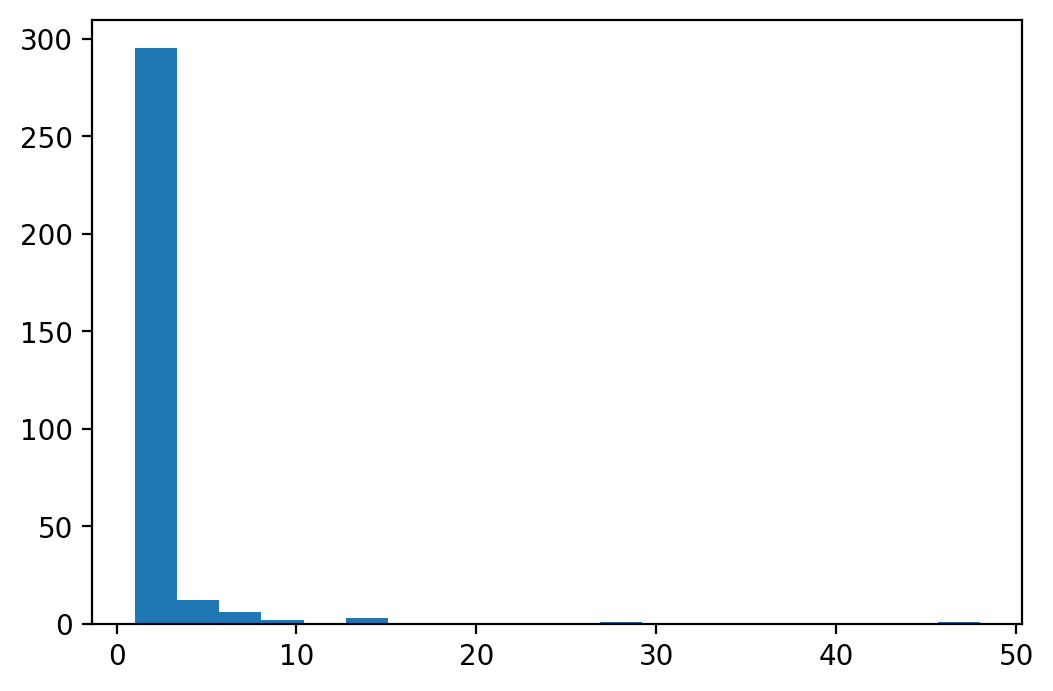

In [27]:
plt.rcParams['figure.dpi'] = 200
clusters = clusteredDf.groupby(by=["cluster"]).agg(list)
clusters["size"] = clusters["key"].apply(len)
plt.hist(clusters["size"], bins=20)

In [99]:
clusters.shape

(320, 2)

In [62]:
## set a cutoff at 40 
clustSorted = clusters.reset_index(drop=True).sort_values("size", ascending=False)
clustList = clustSorted.iloc[7, 0]
print(len(clustList))
for item in clustList: 
    print(item)

8
bostonherald_Murray:_Jim_Lyons_stands_for_traditional_conservative_values
bostonherald_Murray:_Jim_Lyons_stands_for_traditional_conservative_values
bostonherald_Murray:_Jim_Lyons_stands_for_traditional_conservative_values
thelowellsun_Republican_state_chairman_needs_to_go
thelowellsun_Republican_state_chairman_needs_to_go
bostonherald_Editorial:_Republican_state_chairman_needs_to_go
bostonherald_Editorial:_Republican_state_chairman_needs_to_go
yahoonews_Massachusetts_GOP_chair_refused_calls_from_within_his_party_to_condemn_a_colleague_who_said_she_was_'sickened'_a_gay_candidate_adopted_children


In [584]:
import scipy.cluster.hierarchy as shc
clusters = shc.linkage(distArr, method="single", metric="euclidean")
shc.dendrogram(Z=clusters)

<ipython-input-584-1930ec7ab893>:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = shc.linkage(distArr, method="single", metric="euclidean")


In [63]:
list(df.loc[df["key"] == "bostonherald_Editorial:_Republican_state_chairman_needs_to_go", "content"])

['With apologies to Mark Twain, if you didn’t believe the state’s Republican Party could become any more of sideshow, just give Jim Lyons and friends a few feuding minutes.\n\nLyons, the former Andover state rep and current chairman of the Republican State Committee, recently accomplished the impossible — making the already irrelevant GOP even more of an outlier.\n\nHe began his herculean feat by refusing to sanction GOP committeewoman Deborah Martell of Ludlow, who said in an email that she was “sickened” to learn that Republican congressional candidate Jeffrey Sossa-Paquette and his partner had adopted two children.\n\nWhile acknowledging Martell’s comment was in poor taste, Lyons not only didn’t defuse the controversy, he managed to inflame it by saying he wouldn’t “force a woman of deep Catholic faith to resign.”\n\nWe didn’t realize bigotry was compatible with Catholicism.\n\nThis example of lame leadership didn’t sit well with Republican lawmakers or the GOP’s LGBTQ bloc.\n\nLast

In [40]:
df[df["key"].str.contains("cnn_Trump's_power")]["key"]

264072    cnn_Trump's_power,_explained
Name: key, dtype: object